# Text Summarization Guide 
# Hyperparameter tunning for training aTransformer model and W&B logging 

SageMaker Model Tuning is flexible and when used with custom code, allows optimization of arbitrary metrics over arbitrary parameters. Hence be aware that depending on your optimization problem, some or the function below may not apply or would require minor editing to be adapted to your problem

This notebook provide code samples demonstrating the flexible analysis capabilities enabled by SageMaker
In this notebook we will describe the most relevant steps to start training a custom algorithm in AWS SageMaker, not using a custom container, showing how to deal with experiments and solving some of the problems when facing with custom models when using SageMaker script mode on. Some basics concepts on SageMaker will not be detailed in order to focus on the relevant concepts.

Following steps will be explained: 
 
1. Create an Experiment and Trial to keep track of our experiments

2. Load the training data to our training instance

3. Create the scripts to train our custom model, a Transformer.

4. Create an Estimator to train our model in a Tensorflow 2.1 container in script mode

5. Create metric definitions to keep track of them in SageMaker

4. Download the trained model to make predictions

5. Resume training using the latest checkpoint from a previous training 


# Problem description

For this project we will develope notebooks and scripts to train a Transformer Tensorflow 2 model to solve a neural machine translation problem, traslating simple sentences from English to Spanish. This problem and the model is extensively described in my Mdeium post ["Attention is all you need: Discovering the Transformer paper"](https://towardsdatascience.com/attention-is-all-you-need-discovering-the-transformer-paper-73e5ff5e0634).



# Data description

For this exercise, we’ll use pairs of simple sentences. The source text will be in English, and the target text will be in Spanish, from the Tatoeba project where people contribute, adding translations every day. This is the [link](http://www.manythings.org/anki/) to some translations in different languages. There you can download the Spanish/English `spa_eng.zip` file; it contains 124,457 pairs of sentences.

# Set up the environment

Let's start by setting up the environment:

First, we will import and load the libraries to use in our project.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sagemaker
from sagemaker import get_execution_role
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner
import pandas as pd
import numpy as np
import time
import pickle
import boto3

import tensorflow as tf

In [3]:
# Create a SageMaker session to work with
sagemaker_session = sagemaker.Session()
# Get the role of our user and the region
role = get_execution_role()
region = sagemaker_session.boto_session.region_name
print(role)
print(region)

arn:aws:iam::223817798831:role/service-role/AmazonSageMaker-ExecutionRole-20200708T194212
us-east-1


## Define global variables and parameters

In [4]:
# Set the variables for data locations
data_folder_name='data'
train_filename = 'cl_Inshorts.csv'
non_breaking_en = 'nonbreaking_prefix.en'

# Set the directories for our nodel output
trainedmodel_path = 'trained_model'
output_data_path = 'output_data'
# Set the name of the artifacts that our model generate (model not included) 
model_info_file = 'model_info.pth'
input_vocab_file = 'in_vocab.pkl'
output_vocab_file = 'out_vocab.pkl'
# Set the absolute path of the train data 
train_file = os.path.abspath(os.path.join(data_folder_name, train_filename))
non_breaking_en_file = os.path.abspath(os.path.join(data_folder_name, non_breaking_en))

Set some model parameters:

In [5]:
SUMM_MAX_LENGTH=18
TEXT_MAX_LENGTH=70

When working with Amazon SageMaker training jobs that will run on containers in a new instance or "vm", the data has to be share using a S3 Storage folder. For this purpose we define the bucket name and the folder names where our inputs and outputs will be stored. In our case we define:
- The **training data** URI: where our input data is located
- The **output folder**: where our training saves the outputs fron our model
- The **checkpoint folder**: where our model uploads the checkpoints


In [6]:
# Specify your bucket name
bucket_name = 'edumunozsala-ml-sagemaker'
project_name = "ts-transformer"

training_data_folder = r'{}/data'.format(project_name)
output_folder = r'{}'.format(project_name)
ckpt_folder = r'{}/ckpt'.format(project_name)

training_data_uri = r's3://' + bucket_name + r'/' + training_data_folder
output_data_uri = r's3://' + bucket_name + r'/' + output_folder
ckpt_data_uri = r's3://' + bucket_name + r'/' + ckpt_folder

In [7]:
training_data_uri,output_data_uri,ckpt_data_uri

('s3://edumunozsala-ml-sagemaker/ts-transformer/data',
 's3://edumunozsala-ml-sagemaker/ts-transformer',
 's3://edumunozsala-ml-sagemaker/ts-transformer/ckpt')

Then we can upload to the training data folder in S3 the files necessary for training: training data, non breaking prefixes for the inputs (English) and the non breaking prefixes for the outputs (Spanish). Once uploaded they can be loaded for training in the SageMaker container.

In [8]:
inputs = sagemaker_session.upload_data(train_file,
                              bucket=bucket_name, 
                              key_prefix=training_data_folder)

sagemaker_session.upload_data(non_breaking_en_file,
                              bucket=bucket_name, 
                              key_prefix=training_data_folder)

's3://edumunozsala-ml-sagemaker/ts-transformer/data/nonbreaking_prefix.en'

# Create an experiment and trial

*Amazon SageMaker Experiments* is a capability of Amazon SageMaker that lets you organize, track, compare, and evaluate your machine learning experiments.

Machine learning is an iterative process. You need to experiment with multiple combinations of data, algorithm and parameters, all the while observing the impact of incremental changes on model accuracy. Over time this iterative experimentation can result in thousands of model training runs and model versions. This makes it hard to track the best performing models and their input configurations. It’s also difficult to compare active experiments with past experiments to identify opportunities for further incremental improvements.

Experiments will help us to organize and manage all executions, metrics and results of a ML project.

In [9]:
# Install the library necessary to handle experiments
!pip install sagemaker-experiments

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/tensorflow2_p36/bin/python -m pip install --upgrade pip' command.


Load the libraries to handle experiments

In [10]:
# Import the libraries to work with Experiments in SageMaker
from smexperiments.experiment import Experiment
from smexperiments.trial import Trial
from smexperiments.trial_component import TrialComponent

Set the experiment and trial name and one tag to help us to identify the reason for this items.

In [11]:
# Set the experiment name
experiment_name=project_name
# Set the trial name 
trial_name="{}-{}".format(experiment_name,'hp-turner')

tags = [{'Key': 'my-experiments', 'Value': 'ts-transformer-hp'}]

You can create an experiment to track all the model training iterations. Experiments are a great way to organize your data science work. You can create experiments to organize all your model development work for : a business use case you are addressing (e.g. create experiment named “customer churn prediction”), or a data science team that owns the experiment (e.g. create experiment named “marketing analytics experiment”), or a specific data science and ML project. Think of it as a “folder” for organizing your “files”.

We will create a Trial to track each training job run. But this is just a simple example, not intented to explore all the capabilities of the product.

In [12]:
# create the experiment if it doesn't exist
try:
    training_experiment = Experiment.load(experiment_name=experiment_name)
    print('Loaded experiment ',experiment_name)
except Exception as ex:
    if "ResourceNotFound" in str(ex):
        training_experiment = Experiment.create(experiment_name=experiment_name,
                                      description = "Experiment to track Transformer for Text Summarization", 
                                      tags = tags)
        print('Created experiment ',experiment_name)
# create the trial if it doesn't exist
try:
    single_gpu_trial = Trial.load(trial_name=trial_name)
    print('Loaded trial ',trial_name)
except Exception as ex:
    if "ResourceNotFound" in str(ex):
        single_gpu_trial = Trial.create(experiment_name=experiment_name, 
                             trial_name= trial_name,
                             tags = tags)
        print('Created trial ',trial_name)

Loaded experiment  ts-transformer
Loaded trial  ts-transformer-hp-turner


## Trackers

Another interesting tool to mention, is Tracker objects. They can store information about different types of topics or objects in our model or training process like inputs, parameters, artifacts or metrics. The tracker is attached to a trial, associating the object to the training job. We can record that information and analyze it later on the experiment. **Note** that only parameters, input artifacts, and output artifacts are saved to SageMaker. Metrics are saved to file.

As an example, we create a Tracker to register the input data and two parameters about how that data is processed in our project.

In [13]:
from smexperiments.tracker import Tracker
# Create the tracker for the inout data
tracker_name='TextPreprocessing'
trial_comp_name = None # Change to a an exsting TrialComponent to load it

try:
    tracker = Tracker.load(trial_component_name=trial_comp_name)
    print('Loaded Tracker ',tracker_name)
except Exception as ex:
    tracker = Tracker.create(display_name=tracker_name)
    tracker.log_input(name="Text Summarization", media_type="s3/uri", value=inputs)
    tracker.log_parameters({
        "Tokenizer": 'Word',
        "Text Max Length": 70,
        "Summ Max Length": 18,
        "Vocab": 16384
    })
    print('Created Tracker ',tracker_name)
    
# Atach the Tracker to the trial
single_gpu_trial.add_trial_component(tracker.trial_component)

Created Tracker  TextPreprocessing


Our last step consist in create the experiment configuration, a dictionary that contains the experiment name, the trial name and the trial component and it will be used to label our training job.

In [14]:
# Create a configuration definition for our experiment and trial
trial_comp_name = 'track-process'
# Set the configuration parameters for the experiment
experiment_config = {'ExperimentName': training_experiment.experiment_name, 
                       'TrialName': single_gpu_trial.trial_name,
                       'TrialComponentDisplayName': trial_comp_name}

Check and show information about the experiment and trial

In [14]:
print('Experiment: ',training_experiment.experiment_name)
# Show the trials in the experiment
#for trial in training_experiment.list_trials():
    #print('Trial: ',trial.trial_name)

#for trial_comp in TrialComponent.list(trial_name=single_gpu_trial.trial_name):
#        print('Trial Components: ',trial_comp)

Experiment:  ts-transformer


## Logging into W&B

Goto your profile page and copy an api key. Add a new cell below and run the following:

!wandb login PASTE_API_KEY_HERE

You only need to run this once as it writes your credentials in your home directory.

W&B looks for a file named secrets.env relative to the training script and loads them into the environment when wandb.init() is called. You can generate a secrets.env file by calling wandb.sagemaker_auth(path="source_dir") in the script you use to launch your experiments. Be sure to add this file to your .gitignore!

In [13]:
#!pip install wandb

     |████████████████████████████████| 1.8 MB 15.1 MB/s eta 0:00:01
     |████████████████████████████████| 128 kB 60.2 MB/s eta 0:00:01
     |████████████████████████████████| 97 kB 13.5 MB/s eta 0:00:01
  Using cached GitPython-3.1.11-py3-none-any.whl (159 kB)
     |████████████████████████████████| 1.0 MB 67.1 MB/s eta 0:00:01
  Using cached gitdb-4.0.5-py3-none-any.whl (63 kB)
  Using cached smmap-3.0.4-py2.py3-none-any.whl (25 kB)
  Created wheel for subprocess32: filename=subprocess32-3.5.4-py3-none-any.whl size=6489 sha256=66d3a4ddd4bdb61a6680c7f8caa6b9febb26f1be89f1f87231cb47548479e542
  Stored in directory: /home/ec2-user/.cache/pip/wheels/44/3a/ab/102386d84fe551b6cedb628ed1e74c5f5be76af8b909aeda09
  Created wheel for promise: filename=promise-2.3-py3-none-any.whl size=21495 sha256=b7c13a8febd78681a0cf4f2ab4a58db78d33f0cf6db886f9d8482fa5aa4744a3
  Stored in directory: /home/ec2-user/.cache/pip/wheels/59/9a/1d/3f1afbbb5122d0410547bf9eb50955f4a7a98e53a6d8b99bd1
Successfully bui

In [12]:
#import wandb

In [14]:
#!wandb login <API_KEY>

[autoreload of google.protobuf.internal.enum_type_wrapper failed: Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 410, in superreload
    update_generic(old_obj, new_obj)
  File "/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 302, in update_class
    if update_generic(old_obj, new_obj): continue
  File "/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/home/ec2-user

wandb: Appending key for api.wandb.ai to your netrc file: /home/ec2-user/.netrc


W&B looks for a file named `secrets.env` relative to the training script and loads them into the environment when `wandb.init()` is called. You can generate a `secrets.env` file by calling `wandb.sagemaker_auth(path="source_dir")` in the script you use to launch your experiments. Be sure to add this file to your .gitignore!

In [ ]:
# run only once when the secrets.env does not exists
#wandb.sagemaker_auth(path="Encoder_Decoder_Attention/train")

# Construct a script for training

Script mode is a training script format for TensorFlow that lets you execute any TensorFlow training script in SageMaker with minimal modification. The SageMaker Python SDK handles transferring your script to a SageMaker training instance. On the training instance, SageMaker's native TensorFlow support sets up training-related environment variables and executes your training script. In this tutorial, we use the SageMaker Python SDK to launch a training job.

Script mode supports training with a Python script, a Python module, or a shell script.

This project's training script was adapted from the Tensorflow model of a Transformer, we develop in a previous post (mentioned previously). We have modified it to handle: 
- the ``train_file``, ``non_breaking_in``and ``non_breaking_out`` parameters passed in with the values of the training data-set, the non breaking prefixes for the input data and the non breaking prefixes for the output data.

- the ``data_dir`` parameter passed in by SageMaker with the value of the enviroment variable `SM_CHANNEL_TRAINING`. This is an S3 path used for input data sharing during training.

- the ``model_dir`` parameter passed in by SageMaker. This is an S3 path which can be used for data sharing during distributed training and checkpointing and/or model persistence. We have also added an argument-parsing function to handle processing training-related variables.

- the local checkpoint path to store the model checkpoints during training. We use the default value ``/opt/ml/checkpoints`` that will be uploaded to S3. We comment this behavior later when defining our estimator.

- At the end of the training job we have added a step to export the trained model, only the weights, to the path stored in the environment variable ``SM_MODEL_DIR``, which always points to ``/opt/ml/model``. This is critical because SageMaker uploads all the model artifacts in this folder to S3 at end of training.

- the ``output_data_dir`` parameter passed in by SageMaker with the value of the enviroment variable `SM_OUTPUT_DATA_DIR`. This is a folder path used to save output data from our model. This folder will be uploaded to S3 to store the output.tar.zip. In our case we need to save the tokenizer for the input texts, the tokenizer for the outputs, the input and output vocab size and the tokens for ``eos`` and ``sos``. 


In addition to the train.py file, our source code folder includes the files:
- model.py: Tensorflow model definition
- utils.py: utility functions to process the text data 
- utils_train.py: contains functions to calculate the loss and learning rate scheduler.


Here is the entire script for the train.py file:

In [13]:
#!pygmentize 'Transformer/train/train.py'

Our source code needs the tensorflow_dataset library and it is not include in the Tensorflow 2.1. container image provided by SageMaker. To solve this issue we explicitly install it in our train.py file using the command `subprocess.check_call([sys.executable, "-q", "-m", "pip", "install", package])`.

# Create a training job using the `TensorFlow` estimator

The `sagemaker.tensorflow.TensorFlow` estimator handles locating the script mode container where the model will run, uploading your script or source code to a S3 location and creating a SageMaker training job. Let's call out a couple important parameters here:

* `source_dir`and `entry_point`, the folder with the source code and the file to run the training.
* `framework_version` is the tensorflow version we want to run our code.
* `py_version` is set to `'py3'` to indicate that we are using script mode since legacy mode supports only Python 2. Though Python 2 will be deprecated soon, you can use script mode with Python 2 by setting `py_version` to `'py2'` and `script_mode` to `True`.
* `code_location` is a S3 folder URI where the `source_dir` will be upload. When the instace starts the content of that folder will be downloaded to a local path, `opt/ml/code`. The `entry_point`, our main code or function, has to be included in that folder.
* `output_path` is the S3 path where all the outputs of our training job will be uploaded when the training ends. In our example we will upload to this S3 folder the local content in the folders `SM_MODEL_DIR` and `SM_OUTPUT_DATA_DIR`.
* the `checkpoint_local_path`and `checkpoint_s3_uri` parameters will be explained in the next section **"Resume training from a checkpoint"**
* `script_mode = True` to set script mode. 

In [15]:
#from sagemaker.tensorflow import TensorFlow
from sagemaker.estimator import Estimator

In [16]:
# Uncomment the type of instance to use
#instance_type='ml.m4.4xlarge'
instance_type='ml.p2.xlarge'
#instance_type='local'

Define variables for account, region and container image:

In [17]:
account = boto3.client('sts').get_caller_identity().get('Account') # aws account 
#container_image = '{}.dkr.ecr.{}.amazonaws.com/{}'.format(account, region, project_name) # algorithm image path in ECR
container_image = '{}.dkr.ecr.{}.amazonaws.com/{}'.format(account, region, project_name) # algorithm image path in ECR
print('container image uri: ',container_image)

container image uri:  223817798831.dkr.ecr.us-east-1.amazonaws.com/ts-transformer


Another important parameter of our Tensorflow estimator is the `instance_type` that is the type of "virtual machine" where the container will run. The values we play around in this project are:
- local: The container will run locally on the notebook instance. this is very useful to debug or verify that our estimator definition is correct and the train.py runs successfully. It is much more faster to run the container locally, the start up time for a remote instance is too long when you are coding and debugging.
- ml.mX.Yxlarge: It is a CPU instance, when you are running your code for a short train, maybe for validation purposes. Check AWS documentation for a list of alternative instance.
- ml.p2.xlarge: This instance use a GPU and it is the preferred one when you want to launch a long running training.

When running in local mode, some estimator functionalities are not available like uploading the checkpoints to S3 and its parameters should not be defined.

Finally we want to mention the definition of metrics. Using a dictionary, we can define a metric name and the regular expression to extract its value from the messages the training script writes on the logs or the stdout during training. Later we can see those metrics in the SageMaker console. We show you how to do it in a following section.


In [18]:
# Define the metrics to search for
metric_definitions = [{'Name': 'train_loss', 'Regex': 'Train: [0-9a-zA-Z. ]+ Loss ([0-9\\.]+)'},
                      {'Name': 'val_loss', 'Regex': 'Validation: [0-9a-zA-Z. ]+ Loss ([0-9\\.]+)'},
                      {'Name': 'val_rouge1', 'Regex': 'Validation: [0-9a-zA-Z. ]+ Rouge1 ([0-9\\.]+)'},
                      {'Name': 'val_rouge2', 'Regex': 'Validation: [0-9a-zA-Z. ]+ Rouge2 ([0-9\\.]+)'},
                      {'Name': 'val_rougel', 'Regex': 'Validation: [0-9a-zA-Z. ]+ RougeL ([0-9\\.]+)'}]

Now, we can define the estimator:

In [19]:
# Create the Tensorflow estimator using a Tensorflow 2.1 container
estimator = Estimator(#entry_point='train_attention.py',
                       #source_dir="Encoder_Decoder_Attention/train",
                       role=role,
                       instance_count=1,
                       instance_type=instance_type,
                       image_uri=container_image,
                       #framework_version='2.2.0',
                       #py_version='py37',
                       output_path=output_data_uri,
                       code_location=output_data_uri,
                       base_job_name='ts-transformer',
                       script_mode= True,
                       #checkpoint_local_path = 'ckpt', #Use default value /opt/ml/checkpoint
                       #checkpoint_s3_uri = ckpt_data_uri,
                       metric_definitions = metric_definitions, 
                       hyperparameters={
                        'epochs': 15,
                        'nsamples': 54000,
                        'n_layers': 6,
                        'n_heads':8,
                        'text_max-len': 70,
                        'summ_max-len': 18,
                        'resume': True,
                        'train_file': 'cl_Inshorts.csv',
                        'non_breaking_in': 'nonbreaking_prefix.en',
                        'non_breaking_out': 'nonbreaking_prefix.en'
                       })


In [20]:
estimator.training_image_uri()

'223817798831.dkr.ecr.us-east-1.amazonaws.com/ts-transformer'

# Define the hyperparameters tuner object

First round of hyperparamters to tune:
hyperparameter_ranges = {
    'enc_layers': IntegerParameter(1, 3),
    'dec_layers': IntegerParameter(1, 2),
    'embedding_dim': CategoricalParameter([128,300]),
    'lstm_units': CategoricalParameter([256, 512]),
    'learning_rate': ContinuousParameter(0.001, 0.01)
}

Better results: Enc layers 1, Dec layers 2, embedding dim 300, lstm units 512, learning rate 0.0025



In [21]:
# Define the sweep
hyperparameter_ranges = {
    'd_model': CategoricalParameter([256, 512]),
    'ffn_dim': CategoricalParameter([256, 512, 1024]),
    'dropout_rate': ContinuousParameter(0.2, 0.4)}

Set the metric to optimize and how: 

In [22]:
objective_metric_name = 'val_rouge2'
objective_type = 'Maximize'

Create the tuner object, setting the hyperparameter ranges, the objetive metric, the count of jobs and the job name prefix.

In [23]:
tuner = HyperparameterTuner(estimator,
                            objective_metric_name,
                            hyperparameter_ranges,
                            metric_definitions,
                            max_jobs=5,
                            max_parallel_jobs=1,
                            objective_type=objective_type,
                            early_stopping_type = 'Auto',
                            base_tuning_job_name='ts-transformer')

# Start the Start a hyperparameter tuning job

To start a hyperparameter tuning job, we call `tuner.fit` method with the a few parameter values.

- An S3 location is used here as the input. `fit` creates a default channel named `'training'`, which points to this S3 location. In the training script we can access the training data from the local location stored in `SM_CHANNEL_TRAINING`. `fit` accepts a couple other types of input as well. See the API doc [here](https://sagemaker.readthedocs.io/en/stable/estimators.html#sagemaker.estimator.EstimatorBase.fit) for details.
- `job_name` the name for the training job.
- `experiment_config` the dictionary with the name of the experiment and trial to attach this job to.


When training starts, the TensorFlow container executes `train.py`, passing `hyperparameters` and `model_dir` from the estimator as script arguments. Because we didn't explicitly define it, `model_dir` defaults to `s3://<DEFAULT_BUCKET>/<TRAINING_JOB_NAME>/model`, so the script execution is as follows:
```bash
python train.py --model_dir s3://<DEFAULT_BUCKET>/<TRAINING_JOB_NAME>/model --epochs=1 --nsamples=5000 ...
```

When training is complete, the training job will upload the saved model and other output artifacts to S3.

In [24]:
# Set the job name and show it
job_name = '{}-{}'.format('ts-trans-hp',time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime()))
print(job_name)

ts-trans-hp-2020-12-31-20-05-12


Calling fit to train a model with TensorFlow 2.1 scroipt.

In [25]:
# Call the fit method to launch the training job
tuner.fit({'training':training_data_uri}, job_name = job_name, wait=False,
              experiment_config = experiment_config)

INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating hyperparameter tuning job with name: ts-trans-hp-2020-12-31-20-05-12


In [44]:
tuner.describe()

{'HyperParameterTuningJobName': 'ts-att-hp-2020-12-01-20-45-35',
 'HyperParameterTuningJobArn': 'arn:aws:sagemaker:us-east-1:223817798831:hyper-parameter-tuning-job/ts-att-hp-2020-12-01-20-45-35',
 'HyperParameterTuningJobConfig': {'Strategy': 'Bayesian',
  'HyperParameterTuningJobObjective': {'Type': 'Minimize',
   'MetricName': 'val_loss'},
  'ResourceLimits': {'MaxNumberOfTrainingJobs': 3,
   'MaxParallelTrainingJobs': 1},
  'ParameterRanges': {'IntegerParameterRanges': [],
   'ContinuousParameterRanges': [],
   'CategoricalParameterRanges': [{'Name': 'embedding_dim',
     'Values': ['"64"', '"128"']},
    {'Name': 'gru_units', 'Values': ['"256"', '"512"']}]},
  'TrainingJobEarlyStoppingType': 'Off'},
 'TrainingJobDefinition': {'StaticHyperParameters': {'_tuning_objective_metric': 'val_loss',
   'att_units': '128',
   'epochs': '3',
   'model_dir': '"s3://edumunozsala-ml-sagemaker/ts-enc-dec-attention/ts-att-hp-2020-12-01-20-45-35/model"',
   'nsamples': '25000',
   'resume': 'false

Save the experiment, then you can view it and its trials from SageMaker Studio

In [26]:
# Save the trial
single_gpu_trial.save()
# Save the experiment
training_experiment.save()

Experiment(sagemaker_boto_client=<botocore.client.SageMaker object at 0x7f7fdaf4d4a8>,experiment_name='ts-enc-dec-attention',experiment_arn='arn:aws:sagemaker:us-east-1:223817798831:experiment/ts-enc-dec-attention',display_name='ts-enc-dec-attention',description='Experiment to track trainings on my tensorflow Transformer Eng-Spa',creation_time=datetime.datetime(2020, 11, 28, 11, 26, 31, 51000, tzinfo=tzlocal()),created_by={},last_modified_time=datetime.datetime(2020, 11, 29, 19, 10, 16, 374000, tzinfo=tzlocal()),last_modified_by={},response_metadata={'RequestId': '9112cee3-4e4d-45c1-bbf5-f6bb4255b97b', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '9112cee3-4e4d-45c1-bbf5-f6bb4255b97b', 'content-type': 'application/x-amz-json-1.1', 'content-length': '92', 'date': 'Tue, 01 Dec 2020 10:35:26 GMT'}, 'RetryAttempts': 0})

# Analyze Results of a Hyperparameter Tuning job

In [3]:
## You must have already run a hyperparameter tuning job to analyze it here.
## The Hyperparameter tuning jobs you have run are listed in the Training section on your SageMaker dashboard.
## Copy the name of a completed job you want to analyze from that list.
## For example: tuning_job_name = 'mxnet-training-201007-0054'.
tuning_job_name = 'ts-att-hp-2020-12-01-20-45-35'

## Track hyperparameter tuning job progress
After you launch a tuning job, you can see its progress by calling describe_tuning_job API. The output from describe-tuning-job is a JSON object that contains information about the current state of the tuning job. You can call list_training_jobs_for_tuning_job to see a detailed list of the training jobs that the tuning job launched.

In [6]:
tuner = sagemaker.tuner.HyperparameterTuner.attach(tuning_job_name)

In [9]:
tuning_job_result = tuner.describe()

In [10]:
#tuning_job_result = sagemaker_session.describe_hyper_parameter_tuning_job(HyperParameterTuningJobName=tuning_job_name)

status = tuning_job_result['HyperParameterTuningJobStatus']
if status != 'Completed':
    print('Reminder: the tuning job has not been completed.')
    
job_count = tuning_job_result['TrainingJobStatusCounters']['Completed']
print("%d training jobs have completed" % job_count)


3 training jobs have completed


Show if there are jobs in the tuner already finished:

In [11]:
from pprint import pprint

if tuning_job_result.get('BestTrainingJob',None):
    print("Best model found so far:")
    pprint(tuning_job_result['BestTrainingJob'])
else:
    print("No training jobs have reported results yet.")

Best model found so far:
{'CreationTime': datetime.datetime(2020, 12, 1, 20, 45, 53, tzinfo=tzlocal()),
 'FinalHyperParameterTuningJobObjectiveMetric': {'MetricName': 'val_loss',
                                                 'Value': 4.423299789428711},
 'ObjectiveStatus': 'Succeeded',
 'TrainingEndTime': datetime.datetime(2020, 12, 1, 20, 58, 37, tzinfo=tzlocal()),
 'TrainingJobArn': 'arn:aws:sagemaker:us-east-1:223817798831:training-job/ts-att-hp-2020-12-01-20-45-35-001-4ff9dd24',
 'TrainingJobName': 'ts-att-hp-2020-12-01-20-45-35-001-4ff9dd24',
 'TrainingJobStatus': 'Completed',
 'TrainingStartTime': datetime.datetime(2020, 12, 1, 20, 48, 31, tzinfo=tzlocal()),
 'TunedHyperParameters': {'embedding_dim': '"128"', 'gru_units': '"512"'}}


## Show best results of our hyperparameter tunning

Fetch all results as DataFrame

In [17]:
#tuner = sagemaker.HyperparameterTuningJobAnalytics(tuning_job_name)
#full_df = tuner.dataframe()
# Convert the analytics to a dataframe
full_df = tuner.analytics().dataframe()
# Set an object to the tuner analytics
tuner_analytics = tuner.analytics()

is_minimize = (tuning_job_result['HyperParameterTuningJobConfig']['HyperParameterTuningJobObjective']['Type'] != 'Maximize')
objective_name = tuning_job_result['HyperParameterTuningJobConfig']['HyperParameterTuningJobObjective']['MetricName']

if len(full_df) > 0:
    df = full_df[full_df['FinalObjectiveValue'] > -float('inf')]
    if len(df) > 0:
        df = df.sort_values('FinalObjectiveValue', ascending=is_minimize)
        print("Number of training jobs with valid objective: %d" % len(df))
        print({"lowest":min(df['FinalObjectiveValue']),"highest": max(df['FinalObjectiveValue'])})
        pd.set_option('display.max_colwidth', -1)  # Don't truncate TrainingJobName        
    else:
        print("No training jobs have reported valid results yet.")
        
df

Number of training jobs with valid objective: 3
{'lowest': 4.423299789428711, 'highest': 4.478499889373779}


,embedding_dim,gru_units,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
2,"""128""","""512""",ts-att-hp-2020-12-01-20-45-35-001-4ff9dd24,Completed,4.4233,2020-12-01 20:48:31+00:00,2020-12-01 20:58:37+00:00,606.0
0,"""64""","""512""",ts-att-hp-2020-12-01-20-45-35-003-0d5b9ba8,Completed,4.4584,2020-12-01 21:18:06+00:00,2020-12-01 21:28:15+00:00,609.0
1,"""128""","""256""",ts-att-hp-2020-12-01-20-45-35-002-e7bf3f88,Completed,4.4785,2020-12-01 21:03:01+00:00,2020-12-01 21:12:18+00:00,557.0


Next we will show how the objective metric changes over time, as the tuning job progresses. For Bayesian strategy, you should expect to see a general trend towards better results, but this progress will not be steady as the algorithm needs to balance exploration of new areas of parameter space against exploitation of known good areas. This can give you a sense of whether or not the number of training jobs is sufficient for the complexity of your search space.

In [18]:
import bokeh
import bokeh.io
bokeh.io.output_notebook()
from bokeh.plotting import figure, show
from bokeh.models import HoverTool

class HoverHelper():

    def __init__(self, tuning_analytics):
        self.tuner = tuning_analytics

    def hovertool(self):
        tooltips = [
            ("FinalObjectiveValue", "@FinalObjectiveValue"),
            ("TrainingJobName", "@TrainingJobName"),
        ]
        for k in self.tuner.tuning_ranges.keys():
            tooltips.append( (k, "@{%s}" % k) )

        ht = HoverTool(tooltips=tooltips)
        return ht

    def tools(self, standard_tools='pan,crosshair,wheel_zoom,zoom_in,zoom_out,undo,reset'):
        return [self.hovertool(), standard_tools]

hover = HoverHelper(tuner_analytics)

p = figure(plot_width=900, plot_height=400, tools=hover.tools(), x_axis_type='datetime')
p.circle(source=df, x='TrainingStartTime', y='FinalObjectiveValue')
show(p)

Loading BokehJS ...

## Analyze the correlation between objective metric and individual hyperparameters

Now you have finished a tuning job, you may want to know the correlation between your objective metric and individual hyperparameters you've selected to tune. Having that insight will help you decide whether it makes sense to adjust search ranges for certain hyperparameters and start another tuning job. For example, if you see a positive trend between objective metric and a numerical hyperparameter, you probably want to set a higher tuning range for that hyperparameter in your next tuning job.

The following cell draws a graph for each hyperparameter to show its correlation with your objective metric.

In [19]:
#ranges = tuner.tuning_ranges
ranges = tuner_analytics.tuning_ranges
figures = []
for hp_name, hp_range in ranges.items():
    categorical_args = {}
    if hp_range.get('Values'):
        # This is marked as categorical.  Check if all options are actually numbers.
        def is_num(x):
            try:
                float(x)
                return 1
            except:
                return 0           
        vals = hp_range['Values']
        if sum([is_num(x) for x in vals]) == len(vals):
            # Bokeh has issues plotting a "categorical" range that's actually numeric, so plot as numeric
            print("Hyperparameter %s is tuned as categorical, but all values are numeric" % hp_name)
        else:
            # Set up extra options for plotting categoricals.  A bit tricky when they're actually numbers.
            categorical_args['x_range'] = vals

    # Now plot it
    p = figure(plot_width=500, plot_height=500, 
               title="Objective vs %s" % hp_name,
               tools=hover.tools(),
               x_axis_label=hp_name, y_axis_label=objective_name,
               **categorical_args)
    p.circle(source=df, x=hp_name, y='FinalObjectiveValue')
    figures.append(p)
show(bokeh.layouts.Column(*figures))

## Show metrics from SageMaker Console

You can monitor the metrics that a training job emits in real time in the **CloudWatch console**:
- Open the CloudWatch console at https://console.aws.amazon.com/cloudwatch/.
- Choose Metrics, then choose /aws/sagemaker/TrainingJobs.
- Choose TrainingJobName.
- On the All metrics tab, choose the names of the training metrics that you want to monitor.


Another option is to monitor the metrics by using the **SageMaker console**.
- Open the SageMaker console at https://console.aws.amazon.com/sagemaker/.
- Choose Training jobs, then choose the training job whose metrics you want to see.
- Choose TrainingJobName.
- In the Monitor section, you can review the graphs of instance utilization and algorithm metrics

It is a simple way to check how your model is "learning" during the training stage.


# Restore the best training job from the hyperparameter tuning



## Attach the hyperparameter tuning job



If we have just trained a model using our estimator variable in this notebook execution, we can skip this step. But probably you trained your model for hours and now you need to restore your estimator variable from a previous training job. Check for the training job you want to restore the model in SageMaker console, copy the name and paste it in the next section of code. And then you call the `attach` method of the estimator object and now you can continue to work with our training job.

In [21]:
## You must have already run a hyperparameter tuning job to analyze it here.
## The Hyperparameter tuning jobs you have run are listed in the Training section on your SageMaker dashboard.
## Copy the name of a completed job you want to analyze from that list.
## For example: tuning_job_name = 'mxnet-training-201007-0054'.
tuning_job_name = 'ts-att-hp-2020-12-01-20-45-35'

Restore the tuning job, attaching it to a HyperparameterTuner object.

In [22]:
tuner = sagemaker.tuner.HyperparameterTuner.attach(tuning_job_name)

Now, we can extract the best estimator from the Tuner object:

In [23]:
estimator = tuner.best_estimator()


2020-12-01 20:58:37 Starting - Preparing the instances for training
2020-12-01 20:58:37 Downloading - Downloading input data
2020-12-01 20:58:37 Training - Training image download completed. Training in progress.
2020-12-01 20:58:37 Uploading - Uploading generated training model
2020-12-01 20:58:37 Completed - Training job completed


In [31]:
job_name = estimator.latest_training_job.job_name

We can skip the next cell if the previous estimator.fit command was executed

In [27]:
# Set the job_name
job_name = estimator.latest_training_job.job_name
print('Job name where the model will be restored: ',estimator.latest_training_job.job_name)

Job name where the model will be restored:  ts-enc-dec-attention-single-gpu-2020-12-01-10-16-36


In [25]:
estimator

In [29]:
print('Dir of model data: ',estimator.model_data)
print('Dir of output data: ',estimator.model_data)
print('Buck name: ',bucket_name)

Dir of model data:  s3://edumunozsala-ml-sagemaker/ts-enc-dec-attention/ts-att-hp-2020-12-01-20-45-35-001-4ff9dd24/output/model.tar.gz
Dir of output data:  s3://edumunozsala-ml-sagemaker/ts-enc-dec-attention/ts-att-hp-2020-12-01-20-45-35-001-4ff9dd24/output/model.tar.gz
Buck name:  edumunozsala-ml-sagemaker


## Download the trained model

The estimator object variable `model_data` points to the `model.tar.gz` file which contains the saved model. And the other output files from our model that we need to rebuild and tokenize or detokenize the sentences can be found in the S3 folder `output_path/output/output.tar.gz`. We can download both files and unzip them.

In [32]:
# Set the model and the output path in S3 to download the data 
init_model_path = len('s3://')+len(bucket_name)+1
s3_model_path=estimator.model_data[init_model_path:]
s3_output_data=output_data_uri[init_model_path:]+'/{}/output/output.tar.gz'.format(job_name)
print('Dir to download traned model: ', s3_model_path)
print('Dir to download model outputs: ', s3_output_data)

Dir to download traned model:  ts-enc-dec-attention/ts-att-hp-2020-12-01-20-45-35-001-4ff9dd24/output/model.tar.gz
Dir to download model outputs:  ts-enc-dec-attention/ts-att-hp-2020-12-01-20-45-35-001-4ff9dd24/output/output.tar.gz


In [33]:
print('Local dir to download the model: ',trainedmodel_path)
print('Local dir to download the outputs: ',output_data_path)

Local dir to download the model:  trained_model


In [35]:
sagemaker_session.download_data(trainedmodel_path,bucket_name,s3_model_path)
sagemaker_session.download_data(output_data_path,bucket_name,s3_output_data)

Next, extract the information out from the model.tar.gz file return by the training job in SageMaker:

In [36]:
!tar -zxvf $trainedmodel_path/model.tar.gz

decoder.index
checkpoint
encoder.data-00000-of-00001
encoder.index
decoder.data-00000-of-00001


Extract the files from output.tar.gz without recreating the directory structure, all files will be extracted to the working directory

In [37]:
!tar -xvzf $output_data_path/output.tar.gz #--strip-components=1

out_vocab.pkl
in_vocab.pkl
model_info.pth


### Import the tensorflow model and load the model

We import the `model.py` file with our model definition but we only have the weights of the model, so we need to rebuild it. The model parameters where saved during training in the `model_info.pth`, we just need to read that file and use the parameters to initiate an empty instance of the model. And then we can load the weights, `load_weights()` into that instance.


In [38]:
from Encoder_Decoder_Attention.serve.enc_dec_att_model import Encoder, Decoder

# Read the parameters from a dictionary
with open(model_info_file, 'rb') as f:
    model_info = pickle.load(f)
print('Model parameters',model_info)

# Create the Encoder
encoder = Encoder(model_info['vocab_size_enc'], model_info['embedding_dim'], 
                      model_info['gru_units'], model_info['batch_size'])
decoder = Decoder(model_info['vocab_size_dec'], model_info['embedding_dim'], 
                      model_info['gru_units'], model_info['batch_size'])
#Load the saved model
# To do: Use variable to store the model name and pass it in as a hyperparameter of the estimator
encoder.load_weights('encoder')
decoder.load_weights('decoder')

Model parameters {'vocab_size_enc': 16384, 'vocab_size_dec': 16384, 'embedding_dim': 128, 'gru_units': 512, 'att_units': 128, 'batch_size': 64}


## Make some predictions

And now everything is ready to make prediction with our trained model:
- Import the `predict.py` file with the functions to make a prediction and to translate a sentence. The code was described in the original post.
- Read the files and load the tokenizer for the input and output sentences
- Call to `traslate` function with the model, the tokenizers, the `sos`and `eos` tokens, the sentence to translate and the max length of the output. It returns the predicted sentence detokenize, a plain text, with the translation. 

In [39]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline 

In [40]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

In [57]:
from Encoder_Decoder_Attention.serve.predict import predict

Load the input and output tokenizer or vocabularis used in the training. We need them to encode and decode the sentences

In [58]:
# Read the parameters from a dictionary
#model_info_path = os.path.join(model_dir, 'model_info.pth')
with open(input_vocab_file, 'rb') as f:
    tokenizer_inputs = pickle.load(f)

with open(output_vocab_file, 'rb') as f:
    tokenizer_outputs = pickle.load(f)


Input sentence: england pacer james anderson clean bowled cheteshwar pujara with an in-swinging delivery in the visakhapatnam test . the ball came back in after pitching and went through the bat and pad of the batsman to knock out the middle stump . the pacer had bowled a short pitch delivery earlier in the over to push the batsman on to the back foot .
Output sentence: <unk> <unk> to <unk> in <unk> <end> 


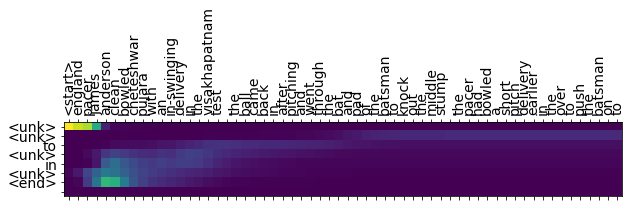

In [60]:
#Show some translations
sentence = "england pacer james anderson clean bowled cheteshwar pujara with an in-swinging delivery in the visakhapatnam test . the ball came back in after pitching and went through the bat and pad of the batsman to knock out the middle stump . the pacer had bowled a short pitch delivery earlier in the over to push the batsman on to the back foot ."
print("Input sentence: {}".format(sentence))
predicted_sentence, sentence, attention_plot = predict(sentence, encoder, decoder, SUMM_MAX_LENGTH, TEXT_MAX_LENGTH,
                             tokenizer_inputs, tokenizer_outputs,model_info['vocab_size_enc'],
                               model_info['gru_units'])
print("Output sentence: {}".format(predicted_sentence))
attention_plot = attention_plot[:len(predicted_sentence.split(' ')), :len(sentence.split(' '))]
plot_attention(attention_plot, sentence.split(' '), predicted_sentence.split(' '))

In [34]:
#Show some translations
sentence = "This is a really powerful method!"
print("Input sentence: {}".format(sentence))
predicted_sentence = translate(transformer,sentence,tokenizer_inputs, tokenizer_outputs,15,model_info['sos_token_input'],
                               model_info['eos_token_input'],model_info['sos_token_output'],
                               model_info['eos_token_output'])
print("Output sentence: {}".format(predicted_sentence))

Input sentence: This is a really powerful method!
Output sentence: ¡Esto es un montón de las carreras de las ocho!


## Delete the experiment

In [31]:
training_experiment.delete_all(action="--force")

# References

- Referencias for experiment and trial
https://github.com/shashankprasanna/sagemaker-training-tutorial/blob/master/sagemaker-training-tutorial.ipynb

- Analyze the result of a hyperparameter tunning job:
https://github.com/aws/amazon-sagemaker-examples/blob/master/hyperparameter_tuning/analyze_results/HPO_Analyze_TuningJob_Results.ipynb
